# Objective : 
1. Group the customers based on their transactional behavior (customer segment). Explain what fields you used to select the customer segment and why from an AML perspective.
2. Identify a minimum of 5 customer IDs connected to transactions that do not fit into the customer's own typical behavior, and/or into the respective customer segments typical behavior. For each of these customers, also explain the reason behind its selection
3. Romania has been recently classified as a high-risk country. Given the rule "Total Monthly Incoming transaction amount from Romania > threshold_value",
4. Recommend an amount threshold for each segment (identified in step 1) to find potential monthly unusual behavior 
Identify customer ID's who would trigger the  new rule

## Approach
AML means identifying transactions by customer history:
1. Too large amounts by incoming/outgoing into customer account 
2. Small amounts but transferred frequently, especially overseas and amt of debits exceeds credits
3. Large transaction volume by one customer
4. Transactions outside country also are suspicious
5. amt of debits should not exceed say 30% amt of credits.

## Importing required files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Reading Data

In [2]:

df = pd.read_csv("transactions.csv",sep=';',header=None)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155181 entries, 0 to 155180
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       155181 non-null  int64 
 1   1       155181 non-null  object
 2   2       155181 non-null  int64 
 3   3       155181 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.7+ MB


In [4]:
df.columns=["Customer_ID", "Transaction_Type",'Total_Amount','Country']

In [5]:
df.head()

,Customer_ID,Transaction_Type,Total_Amount,Country
0,8345,Debit,4342,SE
1,3138,Debit,5852,SE
2,5233,Debit,3517,SE
3,8634,Debit,5325,DK
4,8076,Credit,4815,SE


In [6]:
df.shape

(155181, 4)

In [7]:
df.describe()

,Customer_ID,Total_Amount
count,155181.000000,155181.000000
mean,5002.995457,4982.829180
std,2880.680223,1724.218339
min,0.000000,-2187.000000
25%,2512.000000,3910.000000
50%,5030.000000,5001.000000
75%,7483.000000,6087.000000
max,9999.000000,244351.000000


In [20]:
# negative debit, means negative amount withdrawn means it is OD account
df['over_draw_account']=0
df.loc[(np.logical_and(df['Total_Amount']<0, df['Transaction_Type'] == 'Debit')),'over_draw_account'] = 1
df['over_draw_account'].value_counts()




0    155136
1        45
Name: over_draw_account, dtype: int64

In [48]:
# negative credit, means negative amount is deposited means it is Fraudulent transaction
# Add new col to tag if transaction is fraudulent or not
df['Fraudulent']=0
df.loc[(np.logical_and(df['Total_Amount']<0, df['Transaction_Type'] == 'Credit')),'Fraudulent'] = 1
df['Fraudulent'].value_counts()


0    155124
1        57
Name: Fraudulent, dtype: int64

In [49]:
df['Country'].value_counts()

FI    51734
DK    51668
SE    51448
RO      331
Name: Country, dtype: int64

In [50]:
df['Transaction_Type'].value_counts()

Credit    77710
Debit     77471
Name: Transaction_Type, dtype: int64

In [51]:
df.isnull().sum()

Customer_ID          0
Transaction_Type     0
Total_Amount         0
Country              0
over_draw_account    0
Fraudulent           0
dtype: int64

## Exploratory Data Analysis (EDA)

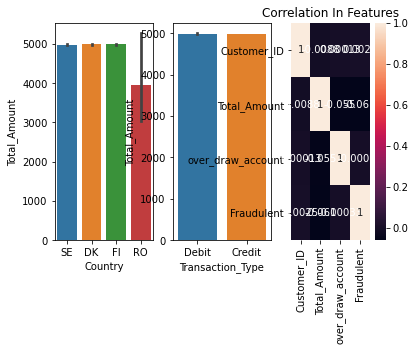

In [52]:
plt.figure(figsize=(20, 10))

ax2=plt.subplot(1,3,1)
sns.barplot(x="Country", y="Total_Amount", data=df,ax=ax2)

ax2=plt.subplot(1,3,2)
sns.barplot(x="Transaction_Type", y="Total_Amount", data=df,ax=ax2)

ax2=plt.subplot(1,3,3)
corr = df.corr()
sns.heatmap(corr,annot = True, ax=ax2)
plt.title("Correlation In Features")

plt.show()

In [65]:
df_trans_history = df[df['Fraudulent'] == 0]
df_trans_history = df_trans_history.groupby(['Customer_ID', 'Transaction_Type', 'Country']).agg({'Total_Amount': ['sum', 'count']})
df_trans_history.reset_index(level=2,inplace=True)
# df_trans_history.head()
df_trans_history.reset_index(inplace=True)
# df_trans_history.columns
df_trans_history.columns=['Customer_ID','Transaction_Type','Country','Total_Amount','Transaction_Count']
df_trans_history['Fraudulent']=0

df_trans_history.head()

,Customer_ID,Transaction_Type,Country,Total_Amount,Transaction_Count,Fraudulent
0,0,Credit,DK,21425,5,0
1,0,Credit,SE,21065,5,0
2,0,Debit,DK,11477,3,0
3,0,Debit,FI,13976,3,0
4,0,Debit,SE,9226,3,0


### 1. First group transactions by customers and identify which customers have high no of transactions

In [ ]:
# 1. Too large amounts by incoming/outgoing into customer account 

In [72]:
df_trans_history.describe()

,Customer_ID,Total_Amount,Transaction_Count,Fraudulent
count,56162.000000,56162.000000,56162.000000,56162.0
mean,4999.809693,13768.540454,2.762081,0.0
std,2886.015855,8179.063634,2.382365,0.0
min,0.000000,-1377.000000,1.000000,0.0
25%,2501.000000,7415.000000,2.000000,0.0
50%,4997.000000,12359.000000,3.000000,0.0
75%,7499.000000,18297.750000,4.000000,0.0
max,9999.000000,244351.000000,219.000000,0.0


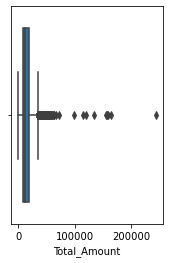

Text(0.5, 1.0, 'Outliers in Total_Amount')

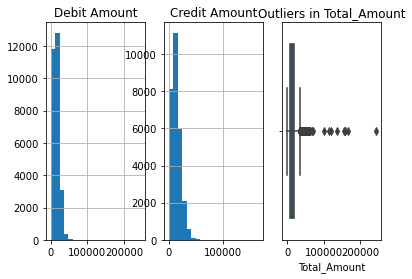

In [86]:
# credit amounts vs debit amounts
plt.figure(figsize=(20, 10))

ax2=plt.subplot(1,3,1)
debit_df = df_trans_history[df_trans_history['Transaction_Type'] == 'Debit']
debit_df['Total_Amount'].hist( bins=20,ax=ax2)
max_amt = np.max(debit_df['Total_Amount'])
# sns.lineplot([ max_amt,0], [max_amt,12000],ax=ax2)
plt.title('Debit Amount')

ax2=plt.subplot(1,3,2)
credit_df = df_trans_history[df_trans_history['Transaction_Type'] == 'Credit']
credit_df['Total_Amount'].hist( bins=20,ax=ax2) 
plt.title('Credit Amount')


# outliers in amount
ax2=plt.subplot(1,3,3)
sns.boxplot( df_trans_history['Total_Amount'],ax=ax2)
plt.title('Outliers in Total_Amount')


In [108]:
# find  transaction amt which which is beyond 99% than the transaction amts made by other customers
# - We consider this amt as threshold
threshold_amt =  np.percentile(df_trans_history['Total_Amount'], 99) 
threshold_amt

38161.39

In [85]:
# There are 562 records having transaction amts between 99%-100% amts
df_trans_history[df_trans_history['Total_Amount'] > threshold_amt].count()

Customer_ID          562
Transaction_Type     562
Country              562
Total_Amount         562
Transaction_Count    562
Fraudulent           562
dtype: int64

In [87]:
# Inspect transactions beyond threshold amount
max_amt_df = df_trans_history[df_trans_history['Total_Amount'] > threshold_amt]
max_amt_df.head()

,Customer_ID,Transaction_Type,Country,Total_Amount,Transaction_Count,Fraudulent
30,5,Debit,SE,42162,7,0
106,19,Debit,DK,43101,6,0
329,59,Credit,FI,38897,6,0
350,63,Credit,SE,46955,9,0
366,66,Debit,DK,40834,7,0


<ipython-input-106-9d381933fefd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_amt_df['amt_bucket'] = pd.qcut(max_amt_df['Total_Amount'],


,amt_bucket,Total_Amount
0,amt0,7359946
1,amt1,7781013
2,amt2,9978239


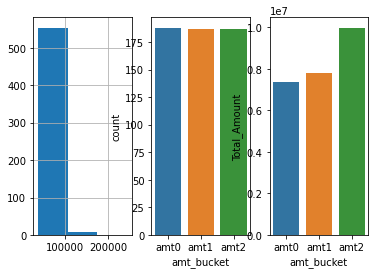

In [106]:
# find amt in each bucket - amt2 has very high value than other 2 segments so we will analyse these customers further
amt_bin_labels = ['amt0', 'amt1', 'amt2']
max_amt_df['amt_bucket'] = pd.qcut(max_amt_df['Total_Amount'],
                              q=3,
                              labels=amt_bin_labels)
amt_bucket_df = pd.DataFrame(max_amt_df.groupby('amt_bucket')['Total_Amount'].sum(), columns=['Total_Amount'])
amt_bucket_df.reset_index(inplace=True)
display(amt_bucket_df)

plt.figure(figsize=(20, 10))

ax2=plt.subplot(1,3,1)
max_amt_df['Total_Amount'].hist( bins=3,ax=ax2) 

ax2=plt.subplot(1,3,2)
sns.countplot(max_amt_df['amt_bucket'],ax=ax2) 

ax2=plt.subplot(1,3,3)
sns.barplot(x=amt_bucket_df['amt_bucket'],y=amt_bucket_df['Total_Amount'],ax=ax2) 
plt.show()

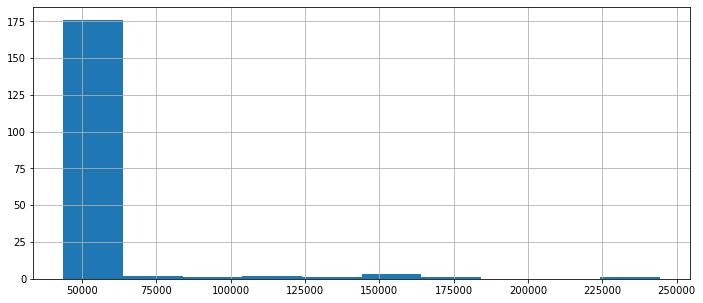

In [121]:
inspect_cust = max_amt_df[max_amt_df['amt_bucket'] == 'amt2']
# inspect_cust.head()

plt.figure(figsize=(40, 5))
ax2=plt.subplot(1,3,1)
inspect_cust['Total_Amount'].hist( bins=10,ax=ax2) 


In [122]:
# Analyzing the very few transactions above 60K amount
inspect_cust = df_trans_history[df_trans_history['Total_Amount'] >= 60000]
len(inspect_cust)

16

In [138]:
# list of cust ids and amt and no of transactions
inspect_cust = inspect_cust.head(len(inspect_cust)).sort_values(['Total_Amount','Transaction_Count'], 
                                                 ascending=[False,False])
inspect_cust = inspect_cust[inspect_cust['Transaction_Count'] > 1]
inspect_cust


lst = list(set(inspect_cust.Customer_ID.tolist()))
len(lst)


8

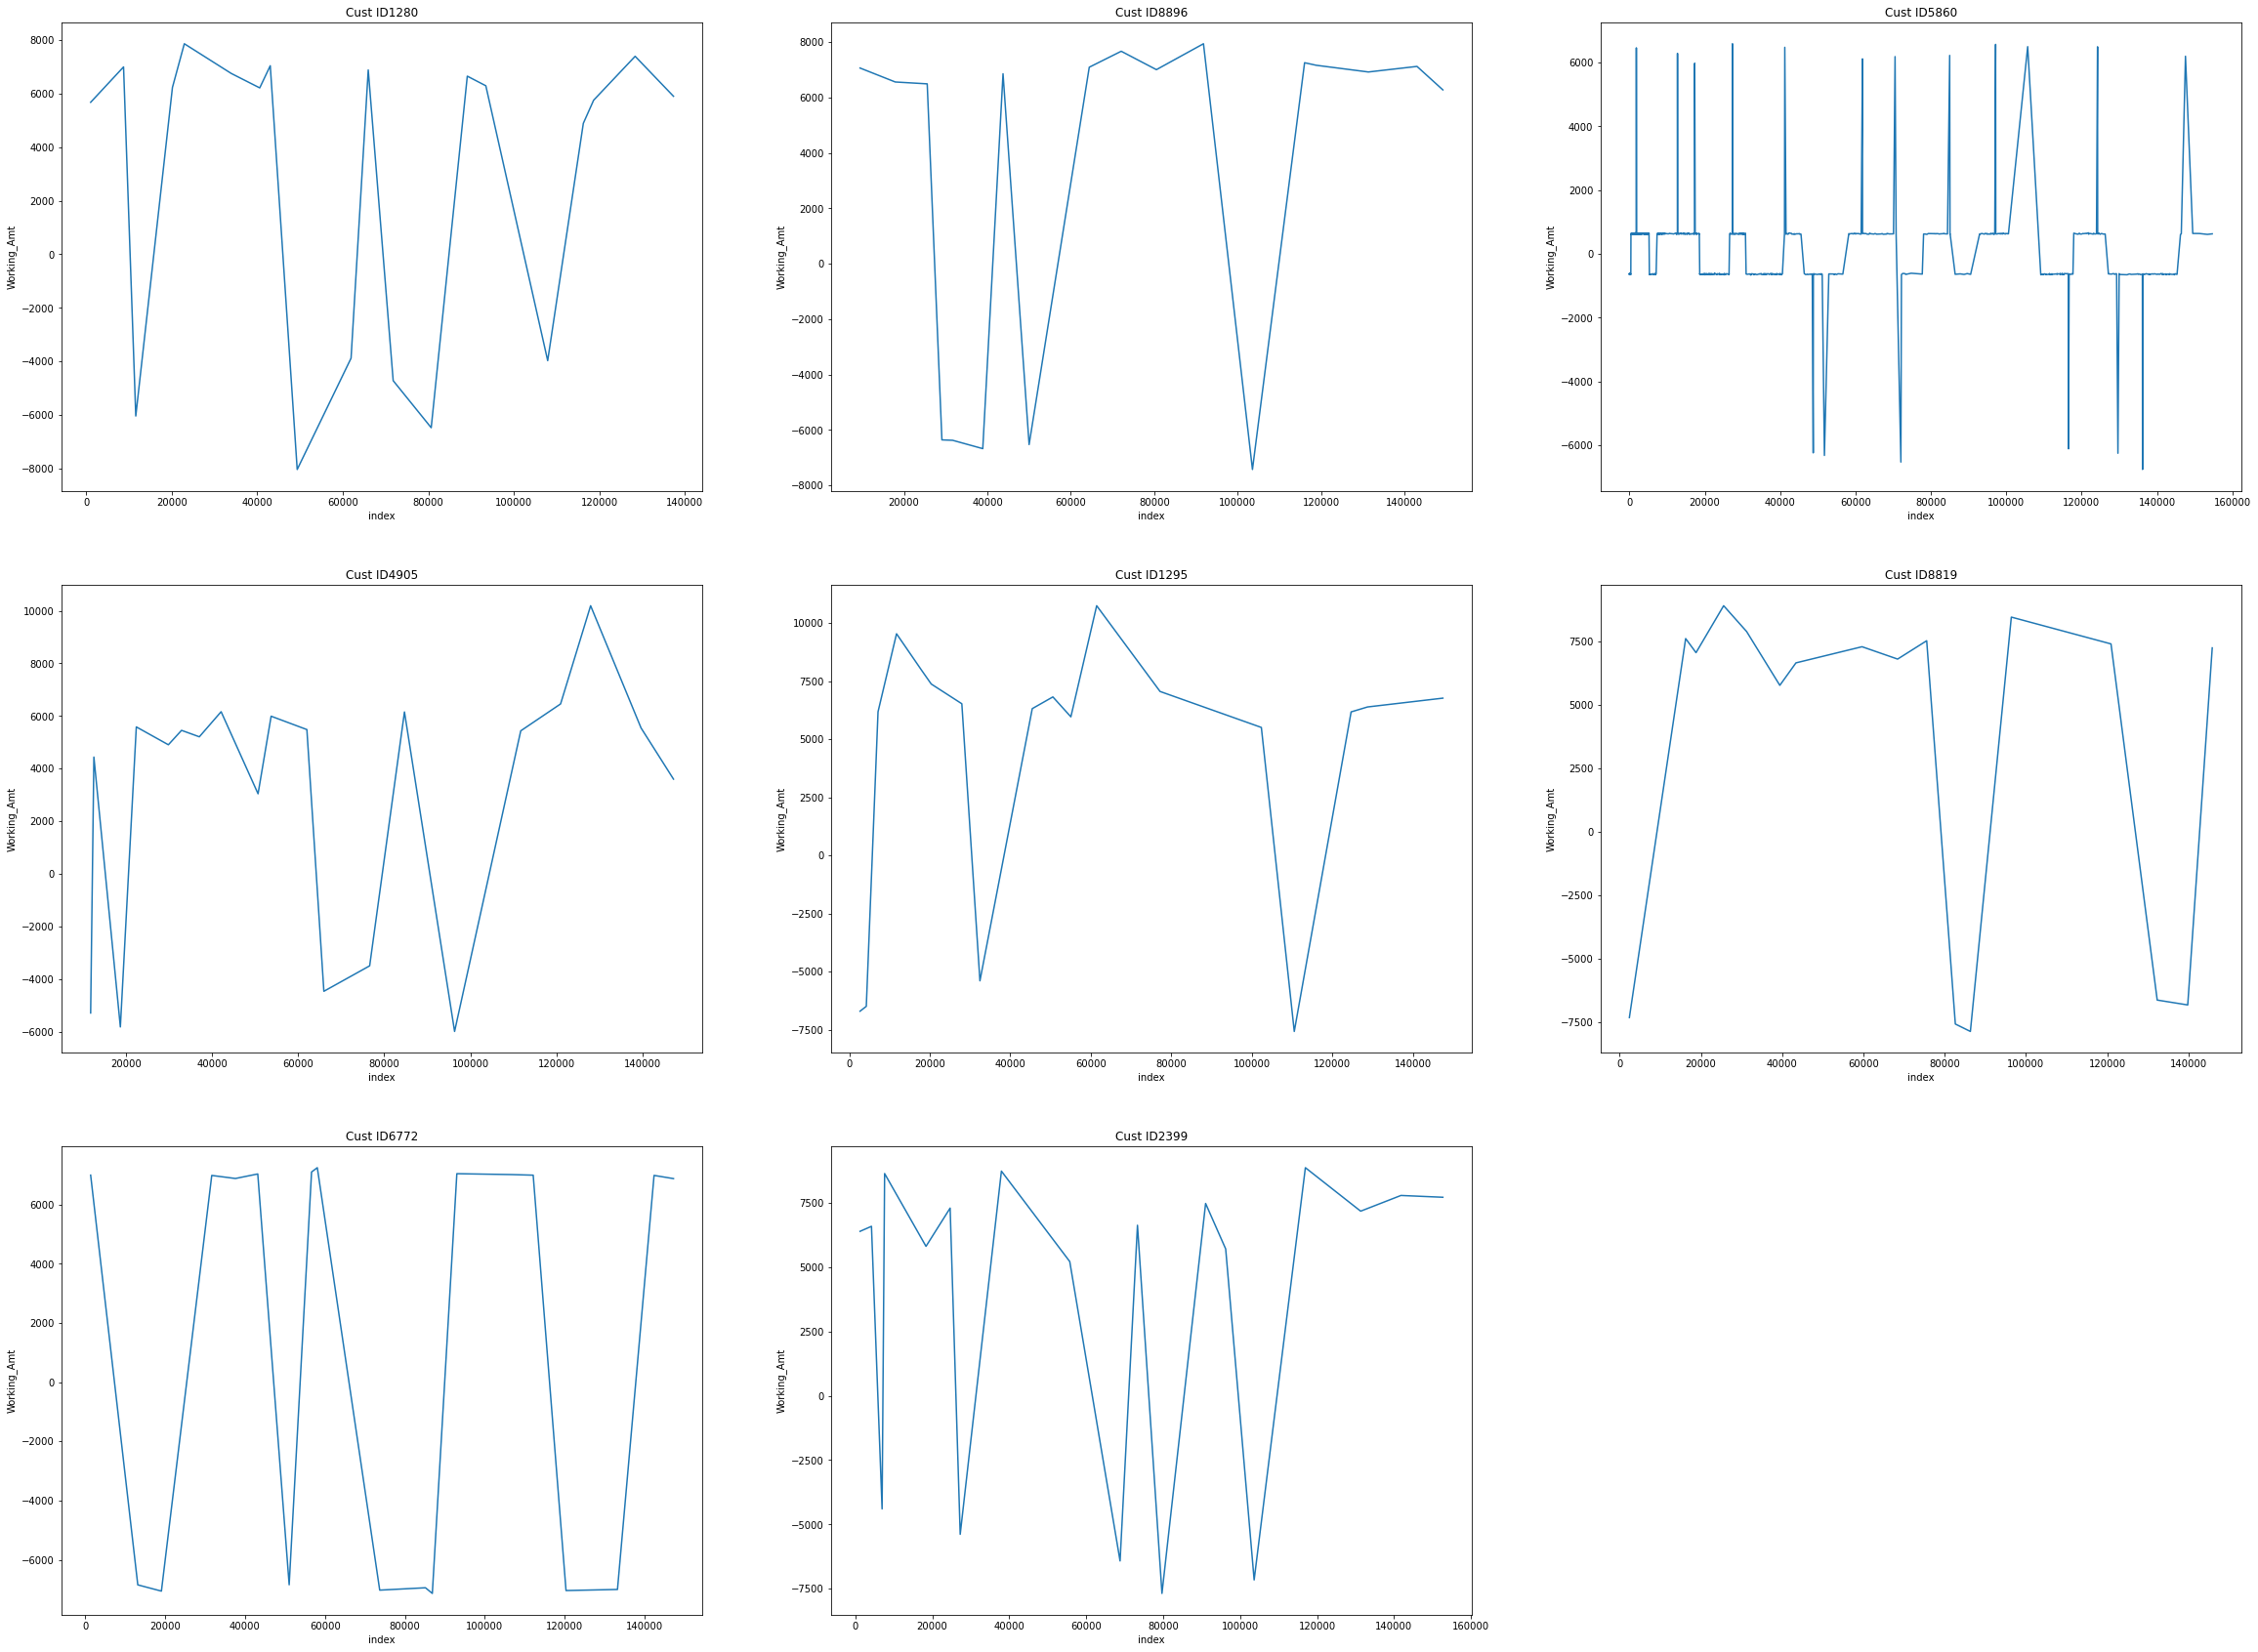

In [189]:
# inspect activities of these 8 customers one by one
t=pd.DataFrame(columns=df.columns)
for c in lst:
    t1= df[df.Customer_ID == c]    
    t=t.append(t1,ignore_index = False)
t.reset_index(inplace=True)
t['Working_Amt']=t['Total_Amount'] 
t.loc[(t['Transaction_Type'] == 'Debit'),'Working_Amt'] = -1*t['Total_Amount']
# t['Working_Amt'].value_counts()

# t.info()
t['Working_Amt']= t['Working_Amt'].astype(float, copy=True, errors='raise')
# t.info()


plt.figure(figsize=(40, 30))
i=1
for c in lst:
    t1= t[t.Customer_ID == c]
#     display(t1)
    bank_bal = np.sum(t1.Working_Amt)
#     print(c, bank_bal)
    ax2=plt.subplot(3,3,i)
    sns.lineplot(x=t1['index'], y=t1.Working_Amt,ax=ax2)
    plt.title('Cust ID'+str(c))
    i=i+1


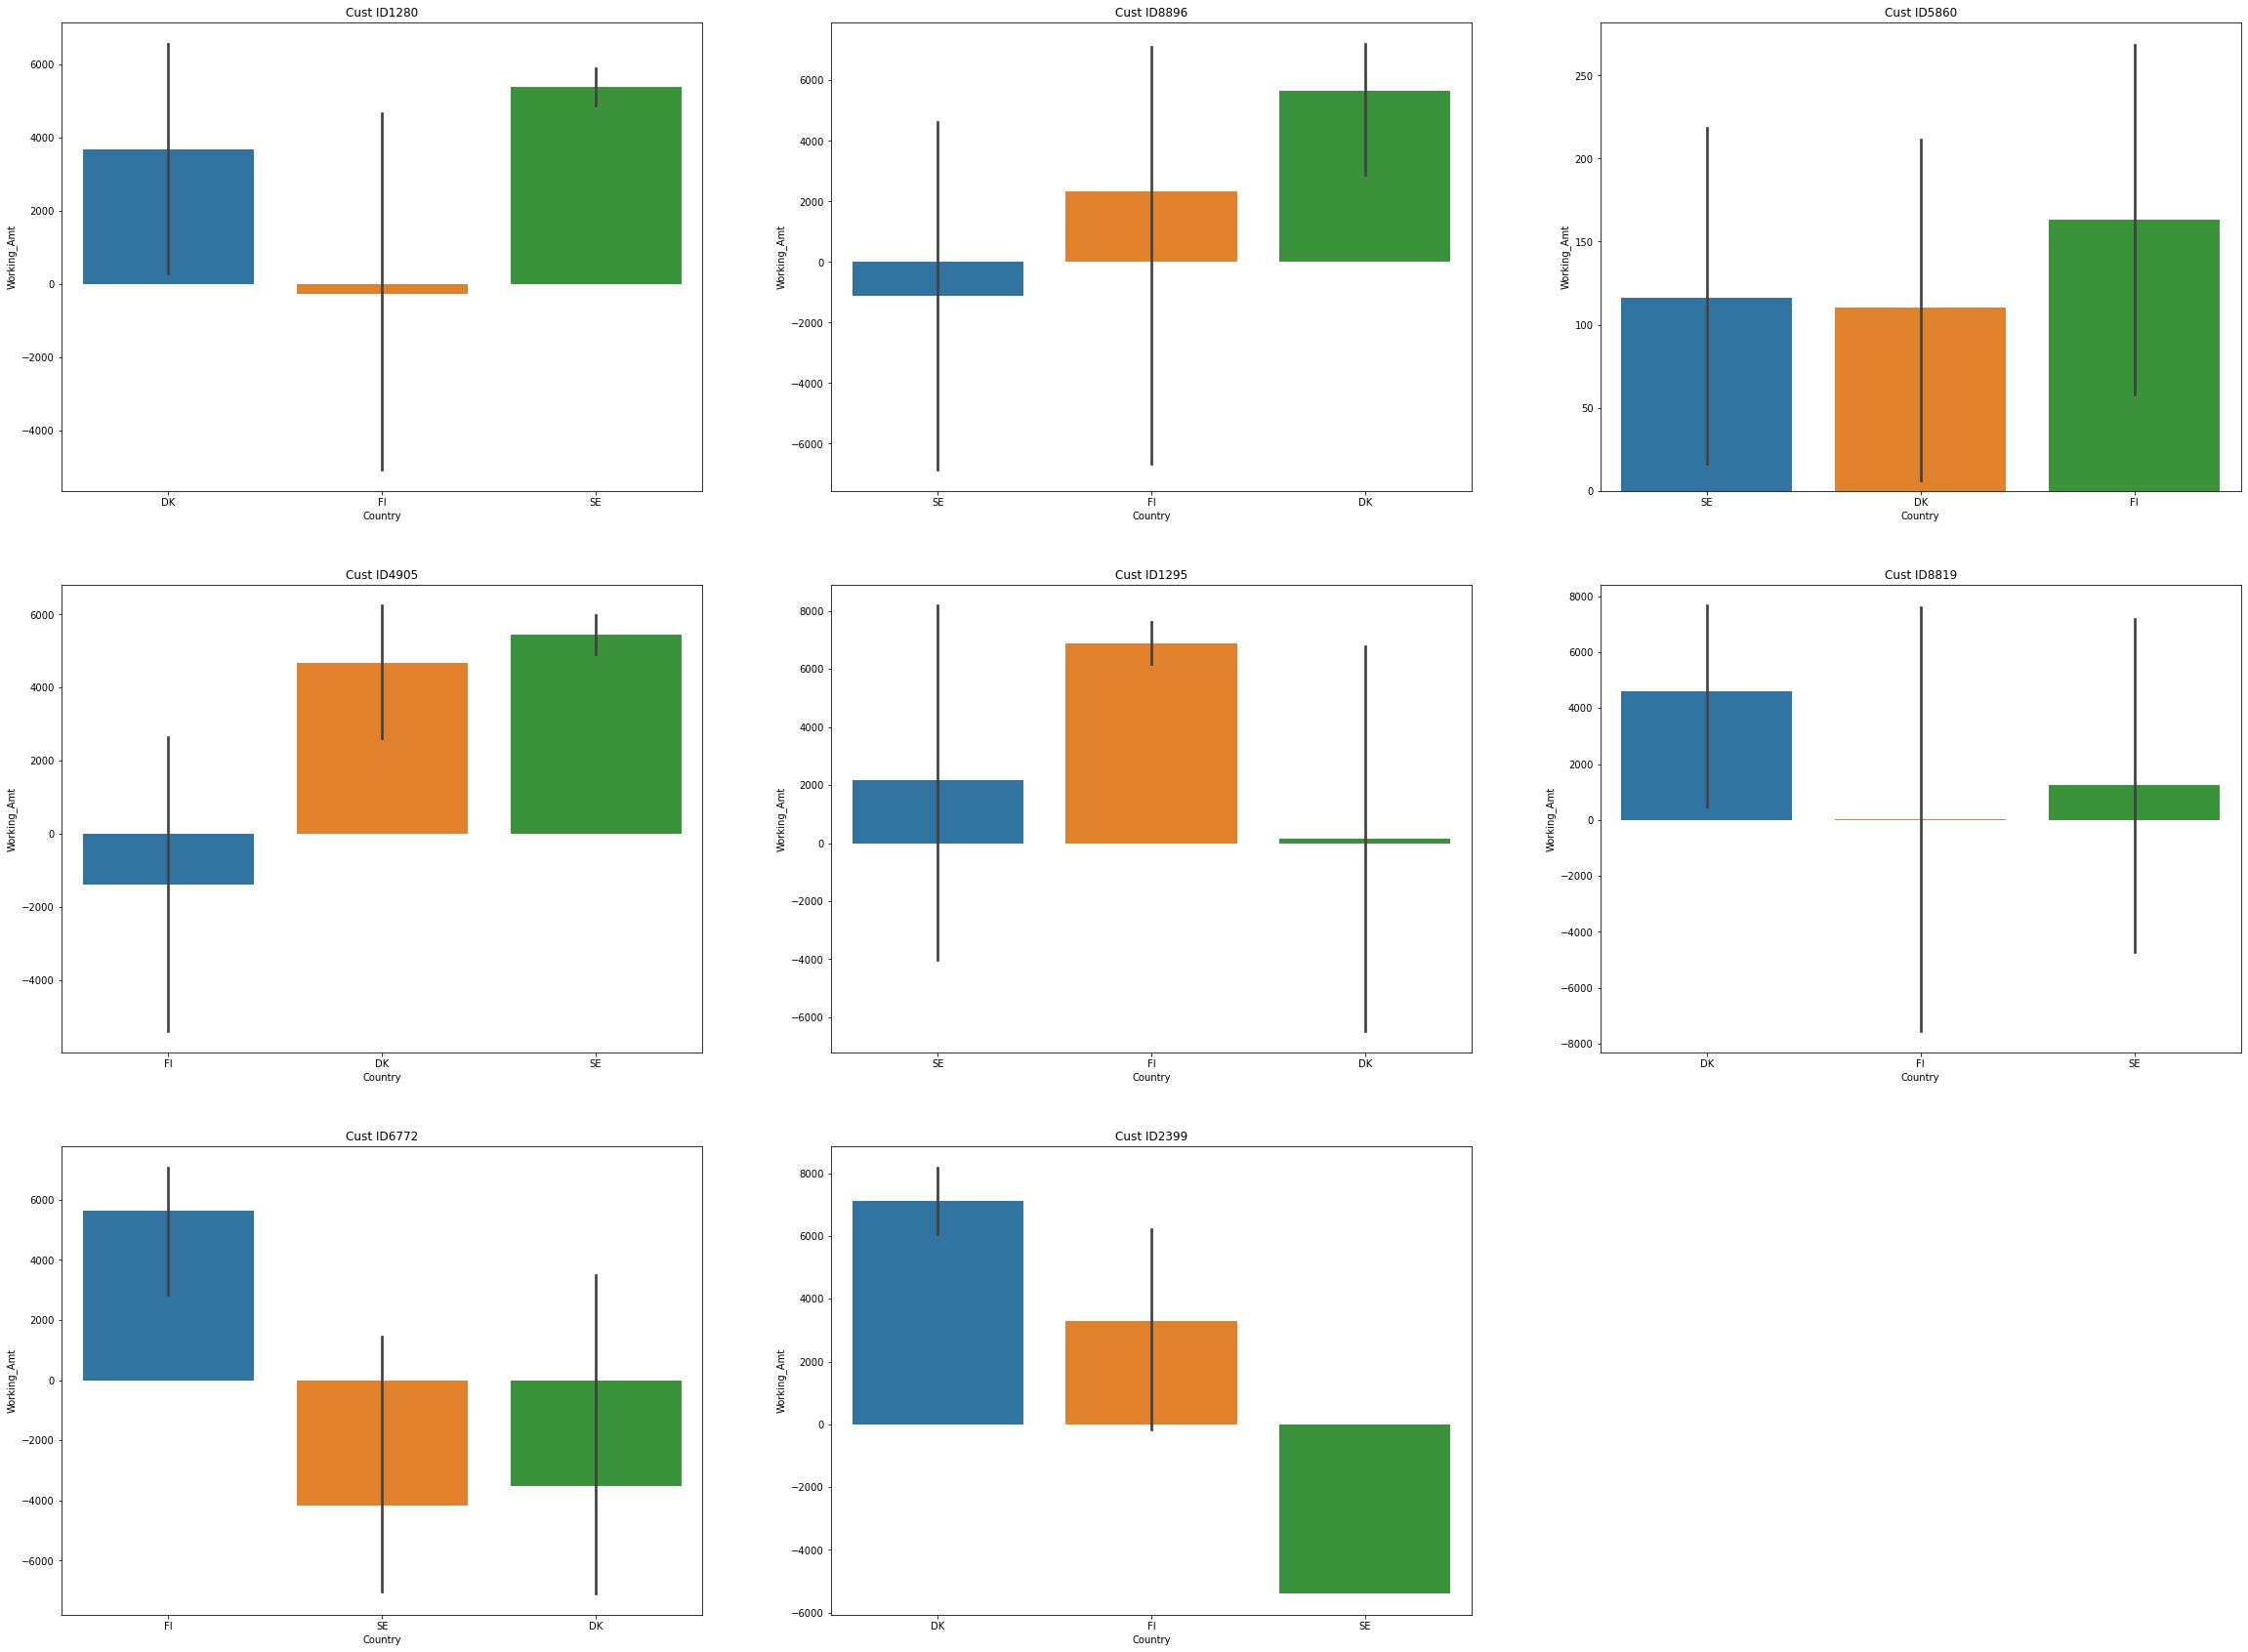

In [218]:
t
plt.figure(figsize=(40, 30))
i=1
for c in lst:
    t1= t[t.Customer_ID == c]
    cntry_trans = pd.DataFrame(t1.groupby(['index','Country','Transaction_Type'])['Working_Amt'].sum(), columns=['Working_Amt'])
    cntry_trans.reset_index(inplace=True)
    cntry_trans.columns=['index','Country','Transaction_Type','Working_Amt']
#     display(cntry_trans)
    ax2=plt.subplot(3,3,i)
    sns.barplot(x=cntry_trans['Country'], y=cntry_trans['Working_Amt'],ax=ax2)
    plt.title('Cust ID'+str(c))
    i=i+1

In [223]:
# Mark 5860 and 8819 as Fraudulent
df.loc[( df['Customer_ID'] == 5860),'Fraudulent'] = 1
df.loc[( df['Customer_ID'] == 8819),'Fraudulent'] = 1
df.loc[( df['Customer_ID'] == 6772),'Fraudulent'] = 1

# Mark other few as Suspicious
df.loc[( df['Customer_ID'] == 2399),'Fraudulent'] = 2
df.loc[( df['Customer_ID'] == 4905),'Fraudulent'] = 2
df.loc[( df['Customer_ID'] == 8896),'Fraudulent'] = 2

##### Conclusion:

We can see lot of interesting patterns here.

Customer ID : 5860 has made too many transactions in the month. 
Also he has made frequent Credit and Debit international transactions. 
Transactions by this customer ID should be tagged as Fraudulent 

Customer ID : 8819 
seems to have credited more, and debited amount only twice. This is odd pattern needs to be inspected. 

Now, 
Customer ID : 6772 has debited more amount from country SE and DK
Similarly cust: 2399, 4905,8896 from one country each. These may not be Fraudulent, but we need to inspect them.

Hence we have marked all of them as Fraudulent.


### 2. Similar to amounts we analyse the no of transactions, especially for international and where debit exceeds credits


# Data Pre-processing

In [226]:
# # Data scaling -
# - Both the datasets have numerical continuous data in wide variety of range. 
# - We will scale them to mean 0 and std dev 1

In [224]:
df.describe()

,Customer_ID,Total_Amount,over_draw_account,Fraudulent
count,155181.000000,1.551810e+05,1.551810e+05,155181.000000
mean,5002.995457,2.331525e-16,3.479888e-18,-0.075075
std,2880.680223,1.000003e+00,1.000003e+00,0.241378
min,0.000000,-4.158320e+00,-1.703138e-02,-0.088168
25%,2512.000000,-6.222139e-01,-1.703138e-02,-0.088168
50%,5030.000000,1.053862e-02,-1.703138e-02,-0.088168
75%,7483.000000,6.403913e-01,-1.703138e-02,-0.088168
max,9999.000000,1.388275e+02,5.871513e+01,11.342028


In [227]:

from sklearn.preprocessing import StandardScaler
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('Customer_ID')
# num_cols
scaler = StandardScaler()
df[num_cols]=scaler.fit_transform(df[num_cols])
df[num_cols].describe()




,Total_Amount,over_draw_account,Fraudulent
count,1.551810e+05,1.551810e+05,1.551810e+05
mean,4.578800e-18,4.029344e-18,-8.095318e-17
std,1.000003e+00,1.000003e+00,1.000003e+00
min,-4.158320e+00,-1.703138e-02,-5.424141e-02
25%,-6.222139e-01,-1.703138e-02,-5.424141e-02
50%,1.053862e-02,-1.703138e-02,-5.424141e-02
75%,6.403913e-01,-1.703138e-02,-5.424141e-02
max,1.388275e+02,5.871513e+01,4.729974e+01


In [ ]:
# One hot encoding

In [231]:
df.columns

Index(['Customer_ID', 'Transaction_Type', 'Total_Amount', 'Country',
       'over_draw_account', 'Fraudulent', 'Working_Amt'],
      dtype='object')

In [243]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155181 entries, 0 to 155180
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Customer_ID        155181 non-null  int64  
 1   Transaction_Type   155181 non-null  object 
 2   Total_Amount       155181 non-null  float64
 3   Country            155181 non-null  object 
 4   over_draw_account  155181 non-null  float64
 5   Fraudulent         155181 non-null  float64
 6   Working_Amt        78099 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 8.3+ MB


In [253]:
t['over_draw_account']= t['over_draw_account'].astype(int, copy=True, errors='raise')
t['Fraudulent']= t['Fraudulent'].astype(int, copy=True, errors='raise')

t.columns
t['Working_Amt']= t['Working_Amt'].apply(lambda x:  float(x))
t['Working_Amt']= t['Working_Amt'].astype(float, copy=True, errors='raise')
# t['Working_Amt'].isnull().sum()
# t['Working_Amt'].value_counts()

 629.0     33
 639.0     32
 633.0     32
 630.0     28
 632.0     26
           ..
 7297.0     1
 7283.0     1
 6529.0     1
-7060.0     1
-3968.0     1
Name: Working_Amt, Length: 250, dtype: int64

In [254]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155181 entries, 0 to 155180
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Customer_ID        155181 non-null  int64  
 1   Transaction_Type   155181 non-null  object 
 2   Total_Amount       155181 non-null  float64
 3   Country            155181 non-null  object 
 4   over_draw_account  155181 non-null  float64
 5   Fraudulent         155181 non-null  float64
 6   Working_Amt        78099 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 8.3+ MB


In [255]:
cat_cols = df.select_dtypes(exclude=['int64','float64']).columns.tolist()
cat_cols

['Transaction_Type', 'Country', 'Working_Amt']

In [258]:
cat_cols.remove('Country')
cat_cols.remove('Working_Amt')

# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(df[cat_cols], drop_first=True)
# dummy1.head()

# Adding the results to the master dataframe
df = pd.concat([df, dummy1], axis=1)
# data.head()

# Drop original cols after adding dummy vars
df = df.drop(df[cat_cols], axis = 1)

df.head()


ValueError: list.remove(x): x not in list

# Data Model Building

# Objective : 1. Group the customers based on their transactional behavior (customer segment). Explain what fields you used to select the customer segment and why from an AML perspective.

# Clustering for Segments

In [ ]:
# We have used no of transactions, transaction amount and country to identify the customer segment

In [ ]:
df_trans_history.columns

In [ ]:
# based on no of transactions we will create 3 buckets [1-5, 5-10, 10+]
# df_trans_history['trans_bucket'] = pd.qcut(df_trans_history['Transaction_Count'], q=3)


trans_bin_labels = ['trans0', 'trans1', 'trans2']
df_trans_history['trans_bucket'] = pd.qcut(df_trans_history['Transaction_Count'],
                              q=3,
                              labels=trans_bin_labels)



# based on transaction amount we have created following customer segments
result=df_trans_history.groupby(['trans_bucket', 'amt_bucket','Transaction_Type_Debit']).agg({'Total_Amount': ['sum']})
result.reset_index(inplace=True)
result.columns=['Transaction_Count_Tag','Amount_Tag','Transaction_Type_Debit','Total_Amount' ]
display(result)
# # df_trans_history.head()
# ax2=plt.subplot(1,2,1)
# result.plot(kind='bar', x='Transaction_Count_Tag', y='Total_Amount',ax=ax2)
# ax2=plt.subplot(1,2,2)
# result.plot(kind='bar', x='Amount_Tag', y='Total_Amount',ax=ax2)

abs(result['Total_Amount']) > 


In [ ]:
df_trans_history.head()

K-Means Clustering
Based on this Euclidean distance metric, we can describe the k-means algorithm as a simple optimization problem, an iterative approach for minimizing the within-cluster sum of squared errors (SSE), which is sometimes also called cluster inertia. So, the objective of K-Means clustering is to minimize total intra-cluster variance, or, the squared error function: 

The steps that happen in the K-means algorithm for partitioning the data are as given follows:

    The algorithm starts with random point initializations of the required number of centers. The “K” in K-means stands for the number of clusters.
    In the next step, each of the data point is assigned to the center closest to it. The distance metric used in K-means clustering is normal Euclidian distance.
    Once the data points are assigned, the centers are recalculated by averaging the dimensions of the points belonging to the cluster.
    The process is repeated with new centers until we reach a point where the assignments become stable. In this case, the algorithm terminates.


The Elbow Method

Using the elbow method to find the optimal number of clusters. The idea behind the elbow method is to identify the value of k where the distortion begins to increase most rapidly. If k increases, the distortion will decrease, because the samples will be closer to the centroids they are assigned to.

This method looks at the percentage of variance explained as a function of the number of clusters. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified.Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.

In [ ]:
# separate as X and Y

In [ ]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('Customer_ID')
num_cols

In [ ]:
df.columns

In [ ]:
print(df.shape)


In [ ]:

# Putting feature variable to X
cols= list(filter(lambda x:x if x not in ['Fraudulent','Customer_ID'] else '', df.columns))
X = df[cols]

# Putting response variable to y
y = df['Fraudulent']

# display(X.head())
# display(y.head())

In [ ]:
X.shape

In [ ]:
X.columns

In [ ]:
y.shape

In [ ]:
df.isnull().sum()

In [ ]:
# IDentify the important features

In [ ]:
# #top important features 
# from sklearn.ensemble import ExtraTreesRegressor

# model = ExtraTreesRegressor()
# model.fit(X,X.index)
# print(model.feature_importances_)

# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.title('Important Features')
# plt.show()

In [ ]:
# print list of correlated feature pairs, as correlation impacts clustering algorithms 

In [ ]:
plt.figure(figsize = (20,5))

#Before dropping features
corr = X.corr()
plt.subplot(1,2,1)
sns.heatmap(corr,annot = True)
plt.title("Correlation")


In [ ]:
# Hopkins test to confirm if data can be clustered

# - If the value is between (0.01, ...,0.3), the data is regularly spaced.
# - If the value is around 0.5, it is random.
# - If the value is between (0.7, ..., 0.99), it has a high tendency to cluster.

# It acts as a statistical hypothesis test where the null hypothesis is that the data is generated by a Poisson point process and are thus uniformly randomly distributed. A value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0.

# Our dataset has <b>hopkins score > 0.9999995664674479 </b>, so our dataset has <b>good tendency to cluster</b>.

In [ ]:
# # Calculating Hopkins score to know whether the data is good for clustering or not.
# from sklearn.neighbors import NearestNeighbors
# from random import sample
# from numpy.random import uniform
# import numpy as np
# from math import isnan

# def hopkin_score(df):
#     d = df.shape[1]
#     n = len(df)
#     m = int(0.1 * n) 
#     nbrs = NearestNeighbors(n_neighbors=1).fit(df.values)
 
#     rand_df = sample(range(0, n, 1), m)
 
#     ujd = []
#     wjd = []
#     for j in range(0, m):
#         u_dist, _ = nbrs.kneighbors(uniform(np.amin(df,axis=0),
#                                             np.amax(df,axis=0),d).reshape(1, -1), 2, return_distance=True)
#         ujd.append(u_dist[0][1])
#         w_dist, _ = nbrs.kneighbors(df.iloc[rand_df[j]].values.reshape(1, -1), 2, return_distance=True)
#         wjd.append(w_dist[0][1])
 
#     HS = sum(ujd) / (sum(ujd) + sum(wjd))
#     if isnan(HS):
#         print(ujd, wjd)
#         HS = 0
 
#     return HS

# hopkin_score(X['Total_Amount'])

In [ ]:
# Various Elbow scores to determine optimal no of clusters for our model


In [ ]:
# Choose the value of K - run thru clusters range 2 to 8 
# Silhouette score
# Elbow curve-ssd

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


num_cols='Total_Amount'
ss = []
inertias = []
distortions=[]
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, max_iter=50,random_state= 0)
    kmeans.fit(X[num_cols])
    kmeans_cluster_labels= kmeans.labels_
    
    silhouette_avg_score = silhouette_score(X[num_cols],kmeans_cluster_labels )
    distortion_score = sum(np.min(cdist(X[num_cols], kmeans.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
    kmeans_inertia_score=kmeans.inertia_
    
    ss.append([k, silhouette_avg_score])   
    distortions.append([k,distortion_score])
    inertias.append([k,kmeans_inertia_score])
    
                       
silhouette_df = pd.DataFrame(ss,columns=['no_of_clusters','silhouette_score'])    
# silhouette_df=silhouette_df.sort_values(by='silhouette_score',ascending=False)
elbow_inertia_df = pd.DataFrame(inertias,columns=['no_of_clusters','kmeans_inertia'])
elbow_distortion_df = pd.DataFrame(distortions,columns=['no_of_clusters','distortion'])
elbows_df = silhouette_df
elbows_df = pd.merge(elbows_df, elbow_inertia_df, on='no_of_clusters')
elbows_df = pd.merge(elbows_df, elbow_distortion_df, on='no_of_clusters')
# display(elbow_distortion_df)
# display(elbow_inertia_df)
# display(silhouette_df)
elbows_df

In [ ]:
# Plot 
titles=['Silhoutte Score Test','Elbow Method using Inertia Test','Elbow Method using Distortion Test']
test_df_list=[silhouette_df,elbow_inertia_df,elbow_distortion_df]
plt.figure(figsize=(15, 5))
i=1
for df in test_df_list:
    ax2 = plt.subplot(1,3,i)
    sns.lineplot(x=X.columns[0],  y = X.columns[1], data = X,ax=ax2)
    plt.xticks(rotation=90)
    plt.title(titles[i-1])
    i = i + 1

plt.suptitle('Finding the Optimal Number of Clusters')
plt.show()



Silhouette analysis on K-Means clustering

Silhouette analysis can be used to study the separation distance between the resulting clusters, as a strategy to quantifying the quality of clustering via graphical tool to plot a measure of how tightly grouped the samples in the clusters are. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

It can also be applied to clustering algorithms other than k-means

Silhouette coefficients has a range of [-1, 1], it calculated by:

    Calculate the cluster cohesion a( i )as the average distance between a sample x( i ) and all other points in the same cluster.
    Calculate the cluster separation b( i ) from the next closest cluster as the average distance between the sample x( i ) and all samples in the nearest cluster.
    Calculate the silhouette s( i ) as the difference between cluster cohesion and separation divided by the greater of the two, as shown here: image Which can be also written as: image

Where:

    If near +1, it indicate that the sample is far away from the neighboring clusters.
    a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
    If most objects have a high value, then the clustering configuration is appropriate.
    If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
    A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters
    Negative values indicate that those samples might have been assigned to the wrong cluster.

The silhouette plot can shows a bad K clusters pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. A good k clusters can found when all the plots are more or less of similar thickness and hence are of similar sizes.

Although we have to keep in mind that in several cases and scenarios, sometimes we may have to drop the mathematical explanation given by the algorithm and look at the business relevance of the results obtained.

Let's see below how our data perform for each K clusters groups (3, 5 and 7) in the silhouette score of each cluster, along with the center of each of the cluster discovered in the scatter plots, by amount_log vs recency_log and vs frequency_log.


In [ ]:
# cluster profiling - Apply k-means with the identified no of clusters

In [ ]:
# Create df_list for 3,4,5 cluster labels
def create_cluster_df(k):
    data_new_df = data.copy()

    kmeans = KMeans(n_clusters=k, max_iter=50,random_state=100)
    kmeans.fit(data_new_df[num_cols])

    # Assign the label
    data_new_df['Cluster_Id'] = kmeans.labels_
    # display(data_new_df.head())
    return data_new_df
    
df_list = []
for k in range(3,6):
    df = create_cluster_df(k)
    df_list.append([k,df])
    
print('Cluster labels added')

In [ ]:
# Number of in each cluster
def plot_compare_cust_counts(df_list):
    plt.figure(figsize=(15, 5))
    i = 1
    for x in df_list:
        k=x[0]
        data_new_df = x[1]
        #     print(data_new_df['Cluster_Id'].value_counts())
        plt.subplot(1,3,i)
        sns.countplot(data_new_df['Cluster_Id'])
        plt.title('Clusters = '+str(k))
        i=i+1
    plt.show()
        
plot_compare_country_counts(df_list)


In [ ]:
# Box plot on various variable Vs Cluster_Id
def plot_compare_economy_vars(df_list):
    plt.figure(figsize=(30, 15))
    cluster_cnt = len(df_list)
    cols=['child_mort','gdpp','income']
    i = 1    
    for x in df_list:
        k=x[0]
        data_new_df = x[1]
        for c in cols:
            plt.subplot(cluster_cnt, 3, i)
            sns.boxplot(x='Cluster_Id', y=c, data=data_new_df, palette="bright")
            plt.xlabel('')
            plt.title('Clusters = '+str(k))
            i = i+1
    plt.show()

    
plot_compare_economy_vars(df_list)


In [ ]:
# Plot Raw data vs Clustered data
final_df=df_list[0][1].copy()
final_df=final_df[['country','Cluster_Id']]
plot_df = data.copy()
plot_df=pd.merge(plot_df,final_df,on='country' )
plot_df['Name'] ='1'
plot_df['Name'] = np.where(plot_df.Cluster_Id == 0,'Developing',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 1,'Underdeveloped',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 2,'Developed',plot_df.Name)
plot_df = plot_df.drop('Cluster_Id',axis=1)
# display(plot_df)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 1)
sns.scatterplot(x='country', y ='gdpp',data=plot_df)
plt.xlabel('')
plt.title('GDPP')

plt.subplot(3, 2, 2)
sns.scatterplot(x='country', y ='gdpp', data=plot_df, hue='Name', legend='full', palette="bright", s=100,
                c='lightblue')
plt.xlabel('')
plt.title('GDPP')

plt.subplot(3, 2, 3)
sns.scatterplot(x='country', y ='income', data=plot_df)
plt.xlabel('')
plt.title('Income')

ax2=plt.subplot(3, 2, 4)
sns.scatterplot(x='country', y ='income', data=plot_df, hue='Name', legend='full', palette="bright", s=100,
                c='lightblue')
plt.xlabel('')
plt.title('Income')

plt.subplot(3, 2, 5)
sns.scatterplot(x='country', y ='child_mort', data=plot_df)
plt.xlabel('')
plt.title('Child Mortality')

plt.subplot(3, 2, 6)
sns.scatterplot(x='country', y ='child_mort', data=plot_df, hue='Name', legend='full', palette="bright", s=100,
                c='lightblue')
plt.xlabel('')
plt.title('Child Mortality')



# Objective : 2. Identify a minimum of 5 customer IDs connected to transactions that do not fit into the customer's own typical behavior, and/or into the respective customer segments typical behavior. For each of these customers, also explain the reason behind its selection
# Objective : 3. Romania has been recently classified as a high-risk country. Given the rule "Total Monthly Incoming transaction amount from Romania > threshold_value",
# Objective : 4. Recommend an amount threshold for each segment (identified in step 1) to find potential monthly unusual behavior 
Identify customer ID's who would trigger the  new rule